In [1]:
### Denoising Adverarial Autoencoder (omniglot) : Version 1 : matching q(z|x*) to p(z)
#if n_hidden==2 uses 2D 10-mix gaussian
#if n_hidden==10 uses 10D normal

In [2]:
from lasagne.layers import InputLayer, DenseLayer, Conv2DLayer, Deconv2DLayer, flatten, reshape, batch_norm
from lasagne.nonlinearities import rectify as relu
from lasagne.nonlinearities import LeakyRectify as lrelu
from lasagne.nonlinearities import sigmoid
from lasagne.layers import get_output, get_all_params, get_output_shape
from lasagne.objectives import binary_crossentropy as bce
from lasagne.objectives import squared_error
from lasagne.updates import adam,sgd

import numpy as np
import theano
from theano import tensor as T
import time
from matplotlib import pyplot as plt 
%matplotlib inline

from skimage.io import imsave

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN

#for log likelihood
from ll import ll
#using code from goodfellow repo insted
from parzen import theano_parzen,get_nll,cross_validate_sigma

floatX=theano.config.floatX

Using gpu device 0: GeForce GT 630 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 4007)


In [3]:
#Options for the network
class options(object):
    def __init__(self):
        self.n_hidden=200  #size of encoding
        self.alpha=1e-5    #learning rate
        self.sigma=0.5     #std of gaussian noise used for corruption
        self.batchsize=64  #batch size used during training
        self.epoch=2000    #number of training iterations
        
myOpts=options()

In [4]:
##Build the networks
def build_net(opts):
    
    #Encoder: x* --> z
    enc=InputLayer(shape=(None,1,105,105))
    enc=flatten(incoming=enc, outdim=2)
    enc=DenseLayer(incoming=enc, num_units=1000, nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=1000,nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=1000,nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=opts.n_hidden,nonlinearity=lrelu(1))
    
    #Decoder: z --> x
    dec=InputLayer(shape=(None,opts.n_hidden))
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=105*105,nonlinearity=sigmoid)
    dec=reshape(incoming=dec, shape=(-1, 1, 105, 105))
    
    #Discriminator: z --> real(1) or fake(0)
    dis=InputLayer(shape=(None,opts.n_hidden))
    dis=DenseLayer(incoming=dis, num_units=1000,nonlinearity=relu)
    dis=DenseLayer(incoming=dis, num_units=1000,nonlinearity=relu)
    dis=DenseLayer(incoming=dis, num_units=1,nonlinearity=sigmoid)
    
    return enc, dec, dis
    

In [5]:
##Make the training, encoding and sampling theano functions
def prep_train(opts):
    #sigma = variation of the gaussian noise used to corrupt the input
    enc,dec,dis=build_net(opts)
    
    #Symbolic vars
    x=T.tensor4('x') #MNIST are saved as vectors
    z=T.matrix('z')

    #The outputs for training:
    rng=T.shared_randomstreams.RandomStreams(np.random.randint(low=1,high=1234))
    corr_x=x+opts.sigma*rng.normal(size=T.shape(x),dtype=floatX) #corrupted x
    enc_x_corr=get_output(enc,corr_x) #enc(x*) encoding corrupted x
    dec_enc_x_corr=get_output(dec,enc_x_corr) #dec(enc(x*)) decoding the encoded input
    p_fake=get_output(dis,enc_x_corr) #D(enc(x)) is decoded x_corr real or fake? fake
    p_real=get_output(dis,z) #D(z) is z real or fake? real
    
    #Prevent bce --> NAN
    p_real=T.clip(p_real, 0.001, 0.999)
    p_fake=T.clip(p_fake,0.001, 0.999)
    dec_enc_x_corr=T.clip(dec_enc_x_corr,0.001,0.99)
    #The outputs for testing:
    samples=get_output(dec,z,deterministic=True) #generated samples
    encoding=get_output(enc,x,deterministic=True) #encoded samples
    reconstruction=get_output(dec,enc_x_corr,deterministic=True) #reconstructed samples

    #The params
    params_enc=get_all_params(enc)
    params_dec=get_all_params(dec)
    params_dis=get_all_params(dis)

    #The loss
    #The reconstruction loss
    J_rec=bce(dec_enc_x_corr,x).mean()

    #The prior matching loss (adv loss)
    J_adv_dis=bce(p_real, T.ones_like(p_real)).mean()+bce(p_fake, T.zeros_like(p_fake)).mean()
    J_adv_enc=bce(p_fake, T.ones_like(p_fake)).mean()

    #The updates
    update_rec=adam(J_rec, params_enc+params_dec,learning_rate=opts.alpha) #update the encoder and decoder w/ reconstruction loss
    update_dis=adam(J_adv_dis, params_dis,learning_rate=opts.alpha) #update the discriminator w/ adversarial loss
    update_enc=adam(J_adv_enc, params_enc,learning_rate=opts.alpha) #update the encoder w/ adversarial loss

    #The theano training functions
    train_rec=theano.function(inputs=[x],outputs=J_rec, updates=update_rec) #trains encoder and decoder using reconstruction loss
    train_dis=theano.function(inputs=[x,z],outputs=J_adv_dis, updates=update_dis) #trains discriminator using adversarial loss
    train_enc=theano.function(inputs=[x],outputs=J_adv_enc, updates=update_enc) #trains encoder only using adversarial loss
    
    #The theano testing functions
    sample=theano.function(inputs=[z],outputs=samples) #
    encode=theano.function(inputs=[x],outputs=encoding) #
    reconstruct=theano.function(inputs=[x], outputs=[squared_error(x,reconstruction),reconstruction])
    
    return train_rec,train_dis,train_enc,  sample,encode,reconstruct, enc,dec,dis
    
    

In [ ]:
#N.B. omni_back_shfl_X and omni_back_shfl_Y were constructed by taking the 
#the first 19 elements in each class, then shuffeling
#this means that to get x_val and y_val I should take the 20th element of
#each class when reading file from omni_back_X

In [6]:
##Load the training, testing and validation datasets
#In paper: x_train is training, x_test is evalusation and x_val is testing data.
#change of notation after code was written
def load_data():
    x_train=np.load('InData/omniglot/omni_back_shfl_X.npy', mmap_mode='r')
    y_train=np.load('InData/omniglot/omni_back_shfl_Y.npy',mmap_mode='r')
    x_test=np.load('InData/omniglot/omni_eval_X.npy',mmap_mode='r')
    y_test=np.load('InData/omniglot/omni_eval_Y.npy', mmap_mode='r')
    
    x_temp=np.load('InData/omniglot/omni_back_X.npy',mmap_mode='r')
    y_temp=np.load('InData/omniglot/omni_back_Y.npy',mmap_mode='r')
    x_val=np.reshape(np.concatenate([x_temp[i] for i in range(0,x_temp.shape[0],20)]),(-1,1,105,105))
    y_val=[y_temp[i] for i in range(0,x_temp.shape[0],20)]
    
    print 'x_train  \t\t | y_train \t| x_test  \t\t| y_test \t  | x_val   \t\t | y_val \n-----------------------------------------------------------------------------------------------------------'
    print np.shape(x_train),'\t',np.shape(y_train),'\t',np.shape(x_test),'\t',np.shape(y_test),'\t\t',np.shape(x_val),'\t',np.shape(y_val)
    return x_train.astype(floatX), y_train, x_test.astype(floatX), y_test, x_val.astype(floatX), y_val

In [7]:
def P_z(size,type=None):
    if size[1] is 2:
        #samples at 2D 10-giassuain mix
        p=np.random.randint(low=0, high=10, size=(size[0],1))
        samples_x=np.zeros((size[0],1))
        samples_y=np.zeros((size[0],1))

        r=4
        theta=np.pi*2/10
        for i in range(10):
            samples_x+=(p==i)*np.random.normal(loc=r*(np.sin(i*theta)+np.cos(i*theta)), scale=0.5, size=(size[0],1))
            samples_y+=(p==i)*np.random.normal(loc=r*(-np.sin(i*theta)+np.cos(i*theta)), scale=0.5, size=(size[0],1))
        return np.hstack([samples_x,samples_y]).astype(floatX)
    else:
        return np.random.normal(size=size).astype(floatX)

In [8]:
##Training function
def train(opts):
    train_rec,train_dis,train_enc,  sample,encode,reconstruct,  enc,dec,dis=prep_train(opts)
    x_train,y_train,x_test,y_test,x_val,y_val=load_data()
    
    batches=int(float(x_train.shape[0])/opts.batchsize)
    
    #Tally of costs
    cost_rec=[] #reconstruction cost of the encoder, decoder net
    cost_dis=[] #aversarial cost on discriminator
    cost_enc=[] #adversarial cost on encoding
    
    n=0
    print 'epoch   batch   cost_dis   cost_enc   cost_rec   time '
    for e in range(opts.epoch):
        timer = time.time()
        for b in np.random.permutation(range(batches)):
            #sample from the prior
            Z=P_z(size=(opts.batchsize,opts.n_hidden))
            X=x_train[b*opts.batchsize:(1+b)*opts.batchsize]
            #train the discriminator
            cost_dis.append(train_dis(X,Z))
            #train the encoder (w/ adversarial) 
            cost_enc.append(train_enc(X))
            #train the autoencer (enc and dec) (w/ reconstruction loss)
            cost_rec.append(train_rec(X))
            
        print "%d \t %d  \t %.3f \t %.3f \t %.3f \t %.2f" % (e,b,cost_dis[-1],cost_enc[-1],cost_rec[-1], time.time()-timer)
    
    return sample,encode,reconstruct, cost_enc,cost_rec,cost_dis
    

In [ ]:
##Training 
sample,encode,reconstruct, cost_enc,cost_rec,cost_dis=train(myOpts)

In [ ]:
#Save all models:
import pickle
dir='DAAE_v1_omni_params'
pickle.dump(sample,open(dir+'/sample.pkl','w'))
pickle.dump(encode,open(dir+'/encode.pkl','w'))
pickle.dump(reconstruct,open(dir+'/reconstruct.pkl','w'))
pickle.dump(myOpts,open(dir+'/myOpts.pkl','w'))
np.save(dir+'/cost_enc.npy',cost_enc)
np.save(dir+'/cost_rec.npy',cost_rec)
np.save(dir+'/cost_dis.npy',cost_dis)

In [9]:
#load all models:
import pickle
dir='DAAE_v1_omni_params/'
#dir='/Experiments/omni/DAAE_v1_noise/DAAE_v1_omni_params/' #dir where my models are saved
sample=pickle.load(open(dir+'/sample.pkl','r'))
encode=pickle.load(open(dir+'/encode.pkl','r'))
reconstruct=pickle.load(open(dir+'/reconstruct.pkl','r'))
myOpts=pickle.load(open(dir+'/myOpts.pkl','r'))
cost_enc=np.load(dir+'/cost_enc.npy')
cost_rec=np.load(dir+'/cost_rec.npy')
cost_dis=np.load(dir+'/cost_dis.npy')

print 'sigma:',myOpts.sigma,', n_hidden',myOpts.n_hidden, 'alpha:', myOpts.alpha, 'epoch', myOpts.epoch

sigma: 0.5 , n_hidden 200 alpha: 1e-05 epoch 1000


In [9]:
x_train,y_train,x_test,y_test,x_val,y_val=load_data()

x_train  		 | y_train 	| x_test  		| y_test 	  | x_val   		 | y_val 
-----------------------------------------------------------------------------------------------------------
(18316, 1, 105, 105) 	(18316,) 	(13180, 1, 105, 105) 	(13180,) 		(964, 1, 105, 105) 	(964,)


x_train  		 | y_train 	| x_test  		| y_test 	  | x_val   		 | y_val 
-----------------------------------------------------------------------------------------------------------
(18316, 1, 105, 105) 	(18316,) 	(13180, 1, 105, 105) 	(13180,) 		(964, 1, 105, 105) 	(964,)


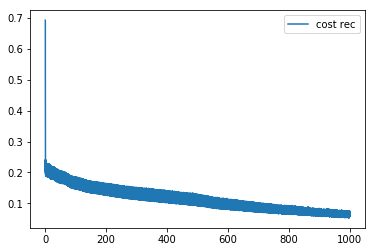

In [10]:
##Training Plots
#Cost plots
x_train,y_train,x_test,y_test,x_val,y_val=load_data()
step=1./int(float(x_train.shape[0])/myOpts.batchsize)
y=np.arange(0,myOpts.epoch,step)
#plt.plot(y,cost_dis,label='cost dis')
#plt.plot(y,cost_enc,label='cost enc')
plt.plot(y,cost_rec,label='cost rec')
plt.legend()

mean squared error loss on eval: 0.0298845 +/- 0.00413457983983


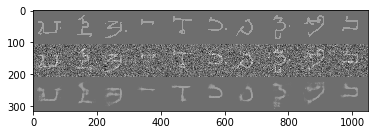

In [11]:
#Apply reconstruction to all the test images
x_rec_loss,x_rec=reconstruct(x_val)
print "mean squared error loss on eval:", np.mean(x_rec_loss),"+/-", np.std(x_rec_loss)/np.sqrt(x_rec_loss.shape[0])
egs=10 #no of random examples to show
x_noise=(x_val[:egs].reshape(egs,105,105)+np.random.normal(loc=0.0, scale=myOpts.sigma, size=(egs,105,105))).reshape(egs,105,105)
plt.imshow(np.hstack(np.hstack(([x_val[:egs].reshape(egs,105,105),x_noise,x_rec[:egs].reshape(egs,105,105)]))),cmap='gray')
plt.figure()

In [12]:
##Classification
#Train a linear SVM on the features from x_train
enc_train=encode(x_train)
enc_val=encode(x_val)
classifier=SVC().fit(enc_train,y_train) #default rbf kernel
y_val=np.asarray(y_val,dtype=int)
score_test=classifier.score(enc_val,y_val)
score_train=classifier.score(enc_train, y_train)
print "mean test accuracy (SVM + RBF kernel):",score_test*100,'%'
print "mean train accuracy (SVM + RBF kernel):",score_train*100,'%'

mean test accuracy (SVM + RBF kernel): 31.7427385892 %
mean train accuracy (SVM + RBF kernel): 67.7276697969 %


In [13]:
## 20 class classfication (for 1st 20 classes of the eval data set using leave one out method)
start=0 # =0 to take 1st 20 (>0 for other subsets - multiple of 20)
enc_test=encode(x_test[start:start+20*20]) #take all 20 examples of 1st 20 classes
print np.shape(enc_test)

all_score_test=[]
all_score_train=[]
for i in range(20): #keep out the ith samples, train on the rest
    print i
    x_20_test=enc_test[i::20]; #take the ith samples for testing
    y_20_test=y_test[start:start+20*20][i::20]; #take the ith samples for testing for 1st 20 classes
    x_20_train=np.delete(enc_test, range(i,enc_test.shape[0],20), axis=0) #remove the ith samples for training
    y_20_train=np.delete(y_test[start:start+20*20], range(i,enc_test.shape[0],20), axis=0) #remove the ith samples for training for the 1st 20 classes

#     print 'stand out samples:\n',range(i,enc_test.shape[0],20)

#     print np.unique(y_20_test),'\n', np.unique(y_20_train)
#     print np.shape(x_20_test), np.shape(x_20_train), np.shape(y_20_test), np.shape(y_20_train)

    classifier=SVC(kernel='linear').fit(x_20_train,y_20_train) #default rbf kernel
    y_val=np.asarray(y_val,dtype=int)
    score_test=classifier.score(x_20_test,y_20_test)
    score_train=classifier.score(x_20_train, y_20_train)
    all_score_test.append(score_test)
    all_score_train.append(score_train)
print "\n mean test accuracy on ", len(all_score_test), "sets of 20-way classification:", np.mean(all_score_test)*100,"%"
print "\n (mean train accuracy on ", len(all_score_train), "sets of 20-way classification:", np.mean(all_score_train)*100,"%"
print "\n max test accuracy on ", len(all_score_test), "sets of 20-way classification:", np.max(all_score_test)*100,"%"

(400, 200)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19

 mean test accuracy on  20 sets of 20-way classification: 83.0 %

 (mean train accuracy on  20 sets of 20-way classification: 100.0 %

 max test accuracy on  20 sets of 20-way classification: 95.0 %


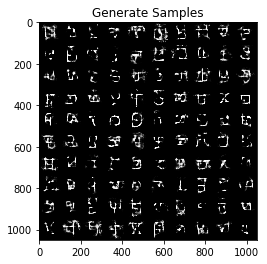

In [14]:
##Samples:
#Draw from the prior and sample (random)
row=col=10
noSamples=row*col
Z=P_z(size=(noSamples,myOpts.n_hidden))
x_samples=sample(Z).reshape(noSamples,105,105)
#display as montage
montage=np.zeros((row*105,col*105))
n=0
for r in range(row):
    for c in range(col):
        montage[r*105:(r+1)*105,c*105:(c+1)*105]=x_samples[n].reshape(105,105); n+=1;
plt.imshow(montage,cmap='gray')
plt.title('Generate Samples')

In [15]:
## "Faster" log likelihood using theano
noSamples=10**3
Z=P_z(size=(noSamples,myOpts.n_hidden))
feats=np.product(x_train.shape[1:]) #number of dimension
print feats
x_sample=sample(Z)
#cross val to find a sigma
batch_size=16
sigma_range = np.logspace(-1, 0, num=10)[:5]
sigma = cross_validate_sigma(x_sample.reshape(-1,feats), x_val.reshape(-1,feats), sigma_range, batch_size)
print "sigma*=",sigma
# fit and evaulate
parzen = theano_parzen(x_sample.reshape(-1,feats), sigma)
ll = get_nll(x_test.reshape(-1,feats), parzen, batch_size = batch_size)
se = ll.std() / np.sqrt(x_test.shape[0])
print "Log-Likelihood of test set = {}, se: {}".format(ll.mean(), se)

# valid
Z=P_z(size=(noSamples,myOpts.n_hidden))
x_sample=sample(Z)
parzen = theano_parzen(x_sample.reshape(-1,feats), sigma)
ll = get_nll(x_val.reshape(-1,feats), parzen, batch_size = batch_size)
se = ll.std() / np.sqrt(x_val.shape[0])
print "Log-Likelihood of valid set = {}, se: {}".format(ll.mean(), se)

11025
0.1
0 8.75974798203 -21424.7257101
0.129154966501
0 4.65132808685 -9557.4700971
0.16681005372
0 4.70995306969 -3572.95869092
0.215443469003
0 4.67900204659 -1115.05926063
0.278255940221
0 4.71846389771 -771.305580964
sigma*= 0.278255940221
0 4.70958304405 -1404.53548195
100 5.00135007943 -1011.88522055
200 5.13741492869 -1112.49421663
300 5.03779417732 -1026.70677759
400 5.18783802225 -1019.87221218
500 5.12094179599 -965.835117949
600 5.11922500217 -934.724538444
700 5.151580248 -890.278005862
800 5.1701270007 -858.754505795
Log-Likelihood of test set = -854.036228549, se: 14.777615667
0 5.01277399063 -818.722988742
Log-Likelihood of valid set = -654.690104995, se: 54.8385740784


In [ ]:
##Iterative sampling (not for experiments 2.)

In [16]:
#display as montage
def montage(X, row=10,col=10):
    plt.figure()
    montage=np.zeros((row*105,col*105))
    n=0
    for r in range(row):
        for c in range(col):
            montage[r*105:(r+1)*105,c*105:(c+1)*105]=X[n].reshape(105,105); n+=1;
    plt.imshow(montage,cmap='gray')
    plt.title('Generate Samples: After MC')

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20


/data/users/ac2211/code/venv/local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iteration: 30
Iteration: 40
final iteration: 50


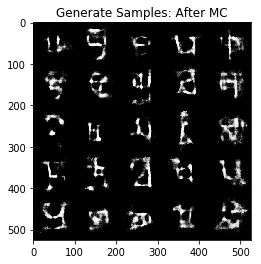

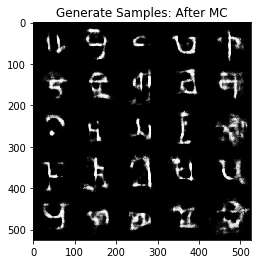

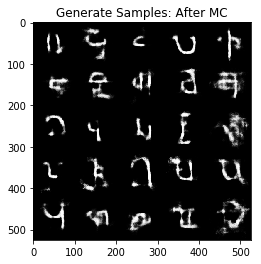

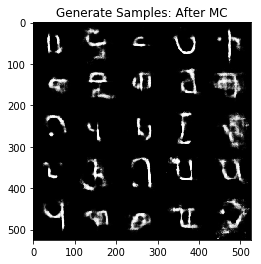

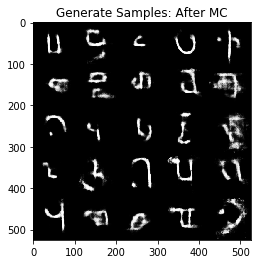

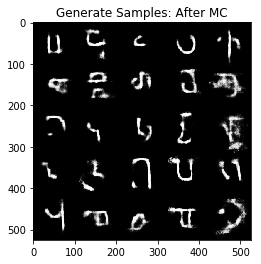

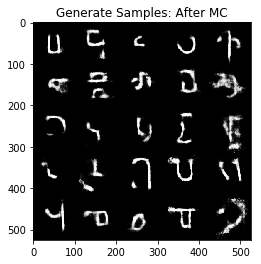

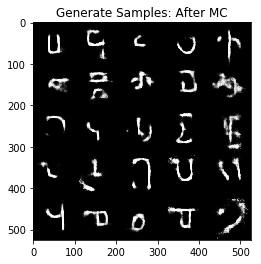

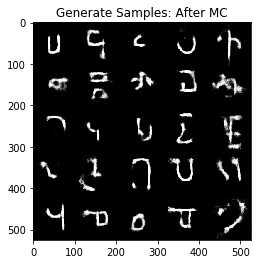

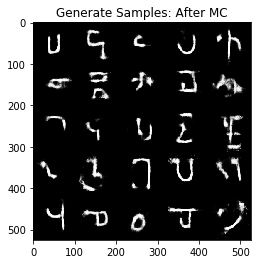

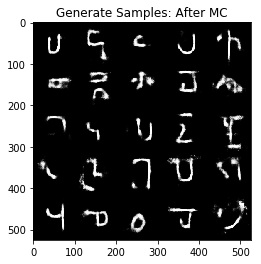

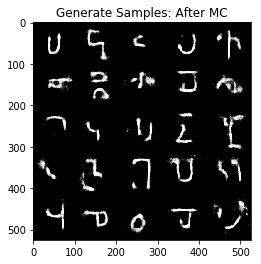

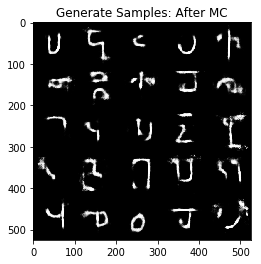

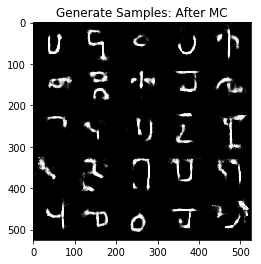

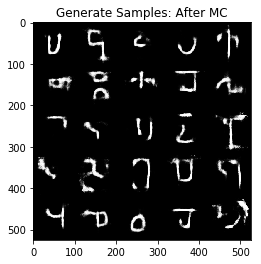

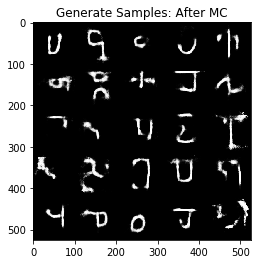

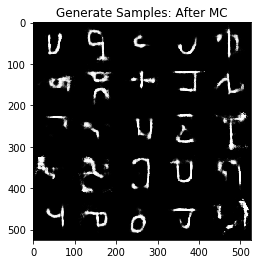

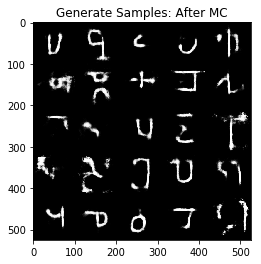

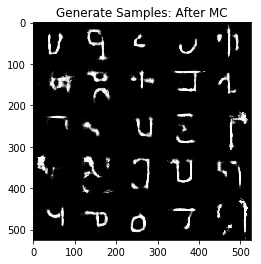

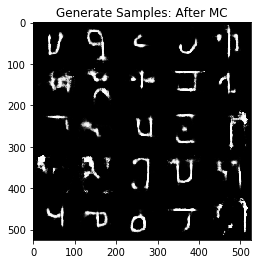

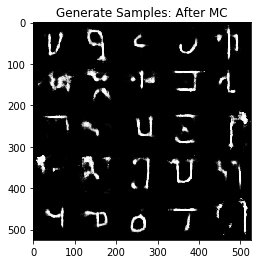

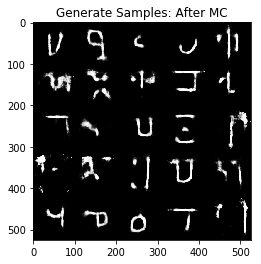

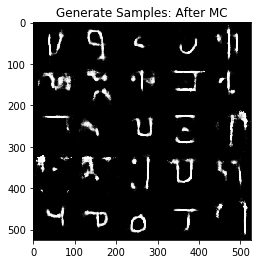

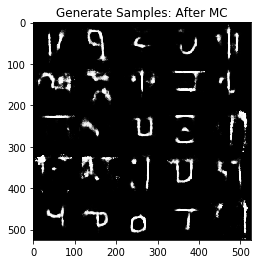

In [17]:
noSamples=10**3
z_0=np.random.normal(size=(noSamples,myOpts.n_hidden)).astype(floatX)
x_t=sample(z_0)
noSteps=50
t=0
sigmas=np.logspace(-1.,0,10)[:5]
for t in range(noSteps):
    if(t%10==0 or t<20):
        print 'Iteration:',t
        montage(x_t,row=5, col=5)
        rec_loss,x_t=reconstruct(x_t)
print 'final iteration:', t+1
montage(x_t, row=5, col=5)

In [18]:
print "sigma*=",sigma
# fit and evaulate
parzen = theano_parzen(x_t.reshape(-1,feats), sigma)
ll = get_nll(x_test.reshape(-1,feats), parzen, batch_size = batch_size)
se = ll.std() / np.sqrt(x_test.shape[0])

print "Log-Likelihood of test set, sample", str(noSteps)," = {}, se: {}".format(ll.mean(), se)

# valid
ll = get_nll(x_val.reshape(-1,feats), parzen, batch_size = batch_size)
se = ll.std() / np.sqrt(x_val.shape[0])
print "Log-Likelihood of valid set = {}, se: {}".format(ll.mean(), se)

sigma*= 0.278255940221
0 31.2905459404 -1513.97008054
100 5.8414540881 -931.101914612
200 8.40944695473 -1031.36805134
300 7.96105257617 -953.806087508
400 7.3989601379 -954.804174142
500 7.51204780904 -907.411192251
600 7.14007736522 -880.164742191
700 7.47785937837 -838.983826623
800 7.41598648168 -806.212041459
Log-Likelihood of test set, sample 50  = -802.805603775, se: 15.2167590361
0 27.1902830601 -748.459583548
Log-Likelihood of valid set = -522.890358537, se: 56.54078551


In [ ]:
exit()